In [1]:
using CSV, DataFrames
using FileIO, Dates
using PyCall
using DelimitedFiles
using CairoMakie

include("./src/cubes.jl")
include("./src/motifs_analysis.jl")

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from '/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/__init__.py'>

In [2]:
function rescale_data(data)
    data_min = minimum(data)
    data_max = maximum(data)
    new_min = 0.0001
    new_max = 1

    old_range = (data_max - data_min)
    new_range = (new_max - new_min)

    new_data = [((((value - data_min) * new_range) / old_range ) + new_min) for value in data]
    # push!(new_data, [((((value - data_min) * new_range) / old_range ) + new_min) for value in data])
    return new_data
end

rescale_data (generic function with 1 method)

alpha= 0.37548759946129423
lambda= 0.0027250818622461402
c= 0.9569158377418648
alpha= 

0.3674967806557422
lambda= 0.004050282355181023
c= 0.9566102886101467


alpha= 0.9239481114829113
lambda= 0.00014747294854133744
c= 0.9396898314527602
alpha= 

0.936442607126673
lambda= 0.00015982841639467825
c= 0.95902480323926


alpha= 0.4486242299788682
lambda= 0.001472719793750179
c= 0.9343663471735889
alpha= 

0.38985996312496624
lambda= 8.451093524127403e-5
c= 0.9691571170499725


alpha= 0.19528436846517508
lambda= 4.7053121448551896e-8
c= 1.2486553970320524
alpha= 

0.1702772574804925
lambda= 8.714141750064666e-8
c= 1.1226520907113002


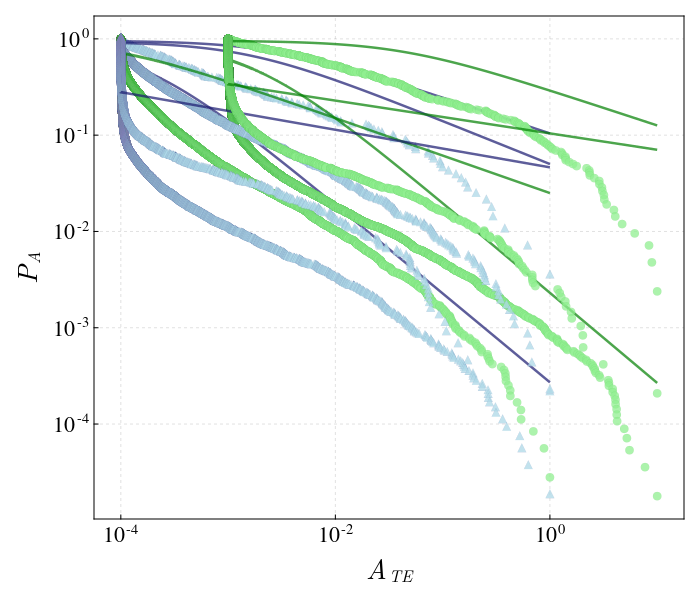

In [18]:
motif = "Triangle"


set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :circle]
colors=[:lightblue, :lightgreen]
line_colors=[:midnightblue, :green]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
    
sc1 = Array{Any,1}(undef,8)


weighted_by = "totalenergy"
for region in ["Romania", "Italy", "California", "Japan"]
    if region == "Romania"
        cell_sizes = [3.0, 3.5];
        minimum_magnitudes = [2];
        all_data_multipliers = [1.0, 10.0]
        multipliers = [1.0, 10.0]
        
    elseif region == "Italy"
        cell_sizes = [4.0, 4.5];
        minimum_magnitudes = [2];
        all_data_multipliers = [1.0, 10.0]
        multipliers = [1.0, 10.0]

    elseif region == "California"
        cell_sizes = [1.0, 2.0];
        minimum_magnitudes = [2];
        all_data_multipliers = [1.0, 1.0]
        multipliers = [1.0, 1.0]
    
    elseif region == "Japan"
        cell_sizes = [2.5, 3.0];
        minimum_magnitudes = [3, 2];
        all_data_multipliers = [1.0, 10.0]
        multipliers = [1.0, 10.0]
    end

    # cell_size = cell_sizes[2]
    minimum_magnitude = minimum_magnitudes[1]

    # Read data
    path = "./data/"
    filepath = path * region * ".csv"
    df = CSV.read(filepath, DataFrame);

    if weighted_by == "totalenergy"
        weight_key = 1
    else 
        weight_key = 2
    end

    # Make path for plot results
    mkpath("./motifs_selected_plots/tsallis/$weighted_by/$region")
    # Read results of fit to get xmin 
    results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);

    for i in eachindex(cell_sizes)
        cell_size = cell_sizes[i]
        if region == "japan"
            minimum_magnitude = minimum_magnitudes[i]
        elseif (region == "romania") | (region == "italy") |  (region == "california")
            minimum_magnitude = minimum_magnitudes[1]
        end
        #############################################################################################################################################################
        # Filter by magnitude
        df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
        # Split into cubes
        df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);
    
        # Get the motif
        network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
        motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
        motifs = readdlm(network_target_path * motif_filename, ',', Int64);
    
        # Energy and areas calculator
        motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
        areas = area_triangles(motifs, df_filtered_cubes);
    
        # Area weighted by total/mean energy
        area_weight = []
        for key in keys(motif_energy)
            # Used to filter out zeros and very small areas (triangles on the vertical for example)
            if areas[key] > 1
                push!(area_weight, areas[key]/motif_energy[key][weight_key])
            end
        end
        #############################################################################################################################################################
        # THE FIT
        x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)

       
        
        fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
        @. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))
        popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=3000)
        println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])
    
        alpha = round(popt_tsallis[1], digits=4)
        lambda = round(popt_tsallis[2], digits=4)
        c = round(popt_tsallis[3], digits=4)
    
        #############################################################################################################################################################

        # rescale data 
        # x_ccdf_original_data = rescale_data(x_ccdf_original_data)
    
        sc1[i] = scatter!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, y_ccdf_original_data,
            color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)
    
        ln1 =  lines!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]),# label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
            color=(line_colors[i], 0.7), linewidth=2.5)
    
    end
end

save("./motifs_selected_plots/tsallis/$weighted_by/motif$(motif)_area_$(weighted_by)_all_data.png", fig, px_per_unit=7)
# save("./motifs_selected_plots/tsallis/$weighted_by/$region/motif$(motif)_$(region)_area_$(weighted_by)_all_data.pdf", fig)
fig 


In [16]:
motif = "Triangle"


set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :circle]
colors=[:lightblue, :lightgreen]
line_colors=[:midnightblue, :green]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
    
sc1 = Array{Any,1}(undef,8)


weighted_by = "totalenergy"

region = "Romania"
cell_sizes = [3.0, 3.5];
minimum_magnitudes = [2];
all_data_multipliers = [1.0, 10.0]
multipliers = [1.0, 10.0]
   

# cell_size = cell_sizes[2]
minimum_magnitude = minimum_magnitudes[1]

# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);

if weighted_by == "totalenergy"
    weight_key = 1
else 
    weight_key = 2
end

# Make path for plot results
mkpath("./motifs_selected_plots/tsallis/$weighted_by/$region")
# Read results of fit to get xmin 
results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);


cell_size = cell_sizes[1]
####################################################################################################################################################
# Filter by magnitude
df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

# Get the motif
network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
motifs = readdlm(network_target_path * motif_filename, ',', Int64);

# Energy and areas calculator
motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
areas = area_triangles(motifs, df_filtered_cubes);

# Area weighted by total/mean energy
area_weight = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if areas[key] > 1
        push!(area_weight, areas[key]/motif_energy[key][weight_key])
    end
end
#############################################################################################################################################################
# THE FIT
x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)


([1.334682569314695e-5, 2.7838677716577356e-5, 3.632394225811188e-5, 4.737364545880616e-5, 4.754038212482515e-5, 4.8683722999884416e-5, 6.557573124265154e-5, 7.792818070220487e-5, 8.559539496490662e-5, 9.203759402501403e-5  …  6.207954612053971, 6.81410329203956, 7.126058118253497, 8.523654370069481, 10.637710758718269, 11.8956445046869, 12.257439953666482, 15.789435704508577, 25.765249920271696, 41.619515348198505], [1.0, 0.9965034965034965, 0.993006993006993, 0.9895104895104895, 0.986013986013986, 0.9825174825174825, 0.9790209790209791, 0.9755244755244755, 0.972027972027972, 0.9685314685314685  …  0.034965034965035, 0.03146853146853146, 0.027972027972028024, 0.02447552447552448, 0.020979020979020935, 0.0174825174825175, 0.013986013986013957, 0.010489510489510523, 0.006993006993006978, 0.0034965034965035446])

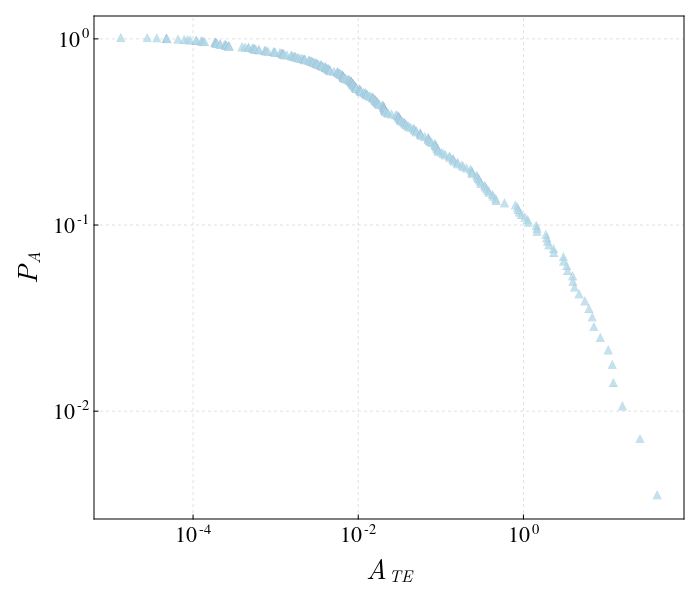

In [17]:
i=1
sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)


fig

In [8]:
x_ccdf_original_data = rescale_data(x_ccdf_original_data)

286-element Vector{Float64}:
 0.0001
 0.00010034816377278493
 0.00010055202051318517
 0.00010081748736644087
 0.00010082149318064659
 0.00010084896171068653
 0.00010125478874440226
 0.00010155155380935186
 0.0001017357570595739
 0.00010189052957078725
 ⋮
 0.16380711345836396
 0.17130176418054288
 0.20487872750280248
 0.25566849867642677
 0.2858900989385478
 0.2945821604010504
 0.3794376339516594
 0.6191045245841453
 1.0

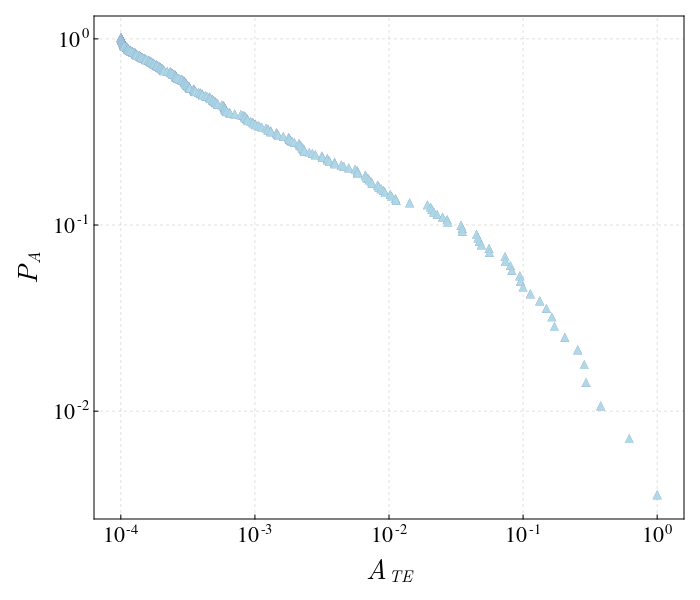

In [15]:
i=1
sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)


fig

In [10]:

# rescale data 
# 1

fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
@. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))
popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=6000)
println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])

alpha = round(popt_tsallis[1], digits=4)
lambda = round(popt_tsallis[2], digits=4)
c = round(popt_tsallis[3], digits=4)

#############################################################################################################################################################

sc1[i] = scatter!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)

ln1 =  lines!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]),# label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
    color=(line_colors[i], 0.7), linewidth=2.5)

end
end

save("./motifs_selected_plots/tsallis/$weighted_by/motif$(motif)_area_$(weighted_by)_all_data.png", fig, px_per_unit=7)
# save("./motifs_selected_plots/tsallis/$weighted_by/$region/motif$(motif)_$(region)_area_$(weighted_by)_all_data.pdf", fig)
fig 


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/gabipana/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError('Optimal parameters not found: The maximum number of function evaluations is exceeded.')
  File "/home/gabipana/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py", line 804, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + res.message)


In [5]:





# if region == "Romania"
#     ylims!(ax1, 10^(-2.8), 10^(0.7))
#     text!(ax1, "Romania", space = :relative, position = Point2f(0.8305, 0.74), fontsize=22)
#     ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
#     ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

#     # multipliers text
#     # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
#     text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.62, 0.72), fontsize=16)
    
#     # AXIS LEGEND
#     # axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
#     # [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
#     # position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

#     # axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

# elseif region == "Italy"
#     ylims!(ax1, 10^(-5), 10^(1.2))

#     text!(ax1, "Italy", space = :relative, position = Point2f(0.87, 0.74), fontsize=22)
#     ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
#     ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

#     # multipliers text
#     # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
#     text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.58, 0.65), fontsize=16)

#     # AXIS LEGEND
#     # axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
#     # [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
#     # position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

#     # axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

# elseif region == "California"
#     ylims!(ax1, 10^(-4.5), 10^(1.2))
#     # xlims!(ax1, 10^(2.5), 5.5)

#     text!(ax1, "California", space = :relative, position = Point2f(0.82, 0.75), fontsize=22)
#     ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
#     ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[ L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

#     # AXIS LEGEND
#     # axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
#     # [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
#     # position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

#     # axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

# elseif region == "Japan"
#     ylims!(ax1, 10^(-5), 10^(1.2))

#     text!(ax1, "Japan", space = :relative, position = Point2f(0.8, 0.8), fontsize=22)
#     ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2), 10^(4)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}", L"10^{4}"])
#     ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

#     # multipliers text
#     # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.37, 0.67), fontsize=16)
#     text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.57, 0.68), fontsize=16)

#     # AXIS LEGEND
#     # axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
#     # [L"L=%$(cell_sizes[i]),\,M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(cell_sizes)],
#     # position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

#     # axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

# end

# text!(ax1, "triangle areas ", space = :relative, position = Point2f(0.21, 0.57), fontsize=18)
# text!(ax1, "weighted by total energy", space = :relative, position = Point2f(0.14, 0.52), fontsize=18)




